#Compressive Sensing using Deep Learning

Due to increaing complexity of devices, the need for more data is constantly increasing, which in turn increases the need for more sensors in a compact region. Although there are state of the art compression models present but most require high computation power to compress. Which is not feasable at a sensor level.
This can be overcome through  compressive sensing, where we measure fewer datapoints, and decode back the full data. Mathematically the problem reduces to finding $X  \in R^m$ given $Y \in R^N$ , $A\in R^{m x n}$ and $N\in R^n$ is gaussian noise: $$Y = AX + N$$ 
The focus of our problem is the situation when $m > n$ ,because we wish to decompress our measured signal, $Y$, with the added assumption that $X$ is sparse. The goal of compressive sensing is to achieve compression greater than what nyquist thorem states, by exploiting the sparseness of the signal. \\
Applications of compressive sensing lies in various fields of study ranging from photography to network tomography. Some existing methods to achieve compressive sensing are: 


*   List item
*   List item

#Project timeline
July - August:
Goal
sept oct 







In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft,dct
from tensorflow.keras.datasets import mnist
from scipy.sparse import random
from keras import layers
from keras.layers import Dense, Dropout, LSTM
from keras.callbacks import EarlyStopping
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from keras import backend as K
from sklearn.linear_model import OrthogonalMatchingPursuit

Schematic flow:
X' is sparse matrix

      X  --Tranform-->   FX  -->  Y = (AFX + noise) --> Neural Network -->  FX'   --Tranform-->  X' --Thresholding-->  X'_thresh

Clarifications: Y is the input to NN X is the output. X and Y are governed by  the equation: Y= AX +B  ,where B is noise

In [ ]:
# Initializations
dimension = 100
equations = 50
A = np.random.rand(equations,dimension)
n = 10000 # no of points to generate
eval_n = 5000 #points to eval/validate model on
test_n = 5000 #testing
mu = 0
test_sigma = 0.2 # mean and std dev for gaussian noise for testing noise , usually kept high
train_sigma = 0.01
min_freq= 0
max_freq = 20 #make sure this is not >= dimension/5
num_of_waves = 10
cardinality = 10
multiplier =1
# print(A)

In [ ]:
#generating db
def generate_db(mu,sigma,A,dimension,equations,n):
  x = np.empty((n,dimension), dtype = np.float32)
  y = np.empty((n,equations), dtype = np.float32)
  for i in range(n):
    tempx = np.random.rand(dimension)
    noise = np.random.normal(mu, sigma, [equations]) 
    tempy = np.matmul(A,tempx) + noise
    x[i] = tempx
    y[i] = tempy
  return x,y
# This is a non vectorized version for sine wave generation, so slow, use when debugging
# def generate_db_sine(mu,sigma,A,dimension,equations,n,min_freq = 0.1,max_freq=20,k=1):
#   Fs = dimension
#   time = np.arange(Fs)/Fs
#   x = np.empty((n,dimension), dtype = np.float32)
#   y = np.empty((n,equations), dtype = np.float32)
#   for i in range(n):
#     f = 13.34935244#np.random.uniform(min_freq,max_freq)
#     phi = np.random.uniform(0,2*np.pi)
#     tempx= np.sin((2 * np.pi * f * time / Fs)+phi)
#     noise = np.random.normal(mu, sigma, [equations]) 
#     tempy = np.matmul(A,tempx) + noise
#     x[i] = tempx
#     y[i] = tempy
#   return x,y,f

def generate_db_sine(mu,sigma,A,dimension,equations,n,
                     min_freq = 0.1,max_freq=25):
  #m = dimension ; n = equations ; A = CS matrix
  Fs = dimension 
  time = np.arange(Fs).reshape(1,Fs)/Fs
  f = np.random.uniform(min_freq,max_freq,(n,1))
  phi = np.random.uniform(0,2*np.pi,(n,1))
  datx = np.cos(((np.outer(time,f)*2*np.pi).T)).T
  noise = np.random.normal(mu, sigma, (equations,n))
  daty = np.matmul(A,datx)+noise
  return datx.T,daty.T

def generate_db_sine_multiple(mu,sigma,A,dimension,
                              equations,n,min_freq =
                              0.1,max_freq=20,k=1):
  x = np.zeros((n,dimension), dtype = np.float32)
  y = np.zeros((n,equations), dtype = np.float32)
  for i in range(k):
    x1,y1 = generate_db_sine(mu,sigma,A,dimension,equations,n,min_freq,max_freq)
    x = np.add(x,x1)
    y = np.add(y,y1)
  return x,y
  
def generate_db_sparse(mu,sigma,num_of_waves,dimension,equations,n,A,cardinality):
  
  x = np.zeros((n,dimension), dtype = np.float32)
  y = np.zeros((equations,n,dimension+1,1), dtype = np.float32)
  y_unmodified = np.zeros((n,equations), dtype = np.float32)
  # sums = np.sum(A,axis =1)
  # print(len(sums),"sums ",sums )
  # A1 = np.reshape(A,(1,dimension*equations))
  # temp = np.ones(n)
  # temp = np.reshape(temp,(n,1))
  # temp = temp*A1
  # print(temp.shape)
  y_ret = np.empty([n, dimension+1,equations])
  for i in range(n):
    x[i] = ((random(1, dimension, density=num_of_waves/dimension).A))
    # print(x[i])
    temp = (x[i]>0).astype(int)
    x[i] = (x[i]*cardinality).astype(int)
    # x[i] = np.reshape(x[i],(dimension,1))
    # x=(x>0).astype(int);
    
    noise = np.random.normal(mu, sigma, (equations))
    y_temp = np.matmul(A,x[i].T)+noise
    # print(y_temp)
    # y_temp = np.divide(y_temp,sums)
    # print(y_temp)
    y_unmodified[i]= y_temp
    y_temp = y_temp.reshape((equations,1))
    # print(x[i].shape,noise.shape,y_temp.shape) 
    # print(y_temp)
    mesa_t = np.append(y_temp,A,axis =1)
    y_ret[i]=(np.transpose(np.array(mesa_t)))
    # flattened = np.reshape(mesa_t,(equations*(dimension+1)))
    # for j in range(equations):
    #   t=flattened[j*(dimension+1):(j+1)*(dimension+1)]
    #   y[j][i]= t.reshape((len(t),1))

  # y_ret = []
  # for j in range(equations):
  #   y_ret.append(y[j])#.reshape((y[j].shape[0],1)))
    # print(temp)
  # print(A)
  #--------
  # x=(x>0).astype(int);
  x= x*multiplier
  # x = x-1
  # y = np.concatenate((y.T,temp),axis =1)
  # print(x,y)
  return y_unmodified,x,y_ret;
  # To save into csv 
  # with open('dbx', 'wb') as dbx:
  #   np.save(dbx,x)

  # with open('dby', 'wb') as dby:
  #   np.save(dby,y)

In [ ]:
# x_train,y_train = generate_db_sine_multiple(mu,train_sigma,A,dimension,equations,n,min_freq,max_freq,num_of_waves)
y_unmodified,x_train,y_train = generate_db_sparse(mu,train_sigma,num_of_waves,dimension,equations,1,A,cardinality)
print(x_train.shape,len(y_train),len(y_train[0]),len(y_train[0][0]),len(y_unmodified),len(y_unmodified[0]))
print(x_train)
print(y_train.shape)
print(y_unmodified.shape)


(1, 100) 1 101 50 1 50
[[3. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 7. 0. 0. 0.
  0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 5. 2. 4. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 5. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 3. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 7. 0. 0. 0.
  0. 0. 0. 0.]]
(1, 101, 50)
(1, 50)


In [ ]:
'''
# The model
def model_noise(x,y,x_test,y_test):
  
  
  y_in = keras.Input(shape=(equations))
  ly = keras.layers.Dense(equations*8, activation='relu')(y_in)# input_shape=[equations+ dimension*equations]),
  y_out = keras.layers.Dense(equations*4, activation='relu')(ly)
  # modely = keras.Model(inputs=y_in, outputs=y_out, name="y_model")
  
  A_in = keras.Input(shape=(dimension*equations))
  lA = keras.layers.Dense(dimension*equations/2, activation='relu')(A_in)# input_shape=[equations+ dimension*equations]),
  A_out = keras.layers.Dense(dimension*equations/100, activation='relu')(lA)# input_shape=[equations+ dimension*equations]),
  # modelA = keras.Model(inputs=A_in, outputs=A_out, name="A_model")
  # print(modely.output.shape,modelA.output.shape)
  combined = tf.keras.layers.concatenate([y_out, A_out])

  lc1 = keras.layers.Dense(dimension*8, activation='relu')(combined)
  lc2 = keras.layers.Dense(dimension*4, activation='relu')(lc1)
    # keras.layers.Dense(dimension, activation='sigmoid') # for sparse 1 0 output
  c_out = keras.layers.Dense(dimension, activation='linear')(lc2) # for sparse 1 0 output
  modelC = keras.Model(inputs=[y_in,A_in], outputs=c_out, name="c_model")

  modelC.compile(loss='mse', optimizer='adam', metrics=['logcosh', 'mse'])
  
  Aa= np.array(A)
  A1 = np.reshape(Aa,(1,dimension*equations))
  temp = np.ones(y.shape[0])
  temp = np.reshape(temp,(y.shape[0],1))
  temp = temp*A1
  temp2 = np.ones(y_test.shape[0])
  temp2 = np.reshape(temp2,(y_test.shape[0],1))
  temp2 = temp2*A1
  print("hello: " ,y.shape,temp.shape)
  z = [y,temp]
  print(len(z),len(z[0]),len(z[0][0]),len(z[1][0]))
  history = modelC.fit([y,temp], x,validation_data=([y_test,temp2],x_test), epochs=200,verbose=0)
  print(modelC.summary())

  #evaluating on trained noise data
  # eval_train_noise = model.evaluate(y[-eval_n:],x[-eval_n:],verbose=0)

  #evaluating on high noise data
  # diff = np.square(high_noise_data[0] - model.predict(high_noise_data[1]))
  # mse_high_noise = (np.apply_along_axis(np.sum,1,diff))/(dimension)
  
  # return np.average(mse_high_noise), eval_train_noise[0],model,history
  return modelC,history

'''

'\n# The model\ndef model_noise(x,y,x_test,y_test):\n  \n  \n  y_in = keras.Input(shape=(equations))\n  ly = keras.layers.Dense(equations*8, activation=\'relu\')(y_in)# input_shape=[equations+ dimension*equations]),\n  y_out = keras.layers.Dense(equations*4, activation=\'relu\')(ly)\n  # modely = keras.Model(inputs=y_in, outputs=y_out, name="y_model")\n  \n  A_in = keras.Input(shape=(dimension*equations))\n  lA = keras.layers.Dense(dimension*equations/2, activation=\'relu\')(A_in)# input_shape=[equations+ dimension*equations]),\n  A_out = keras.layers.Dense(dimension*equations/100, activation=\'relu\')(lA)# input_shape=[equations+ dimension*equations]),\n  # modelA = keras.Model(inputs=A_in, outputs=A_out, name="A_model")\n  # print(modely.output.shape,modelA.output.shape)\n  combined = tf.keras.layers.concatenate([y_out, A_out])\n\n  lc1 = keras.layers.Dense(dimension*8, activation=\'relu\')(combined)\n  lc2 = keras.layers.Dense(dimension*4, activation=\'relu\')(lc1)\n    # keras.laye

In [ ]:
# def custom_mse(y_true, y_pred):
#         return K.square(K.mean(K.square(y_pred - y_true)))
# The model
def model_noise(x,y,x_test,y_test):
  # layers = []
  # inputs = []
  lrelu = lambda x: tf.keras.activations.relu(x, alpha=0.05)
  # for i in range(0,equations):
  model = keras.models.Sequential()
  # input_l  = keras.Input(shape=(dimension+1,equations))  
  model.add(layers.LSTM(dimension,input_shape=((dimension+1,equations)) ,activation="tanh", recurrent_activation="sigmoid",use_bias=True,
                        return_sequences=True))
  model.add(layers.LSTM(dimension, activation="tanh",recurrent_activation="sigmoid",use_bias=True,return_sequences=False))
  model.add(layers.Dense(dimension*2, activation=lrelu))

  # added_layer = keras.layers.Average()(layers)
  # print(len(layers),layers[0].shape)
  # print(len(inputs),inputs[0].shape)
  print(multiplier, "in func")

  # model.add(layers.Dense(dimension*8, activation=lrelu))
  # lc2 = keras.layers.Dense(dimension*4, activation= lrelu)(lc1)
  # lc3 = keras.layers.Dense(dimension*2, activation= lrelu)(lc2)
  # model.add(layers.Dense(dimension*2, activation= lrelu))
  # keras.layers.Dense(dimension, activation='sigmoid') # for sparse 1 0 output
  model.add(layers.Dense(dimension, activation='linear'))# for sparse 1 0 output
  
  # modelC = keras.Model(inputs = input_l,outputs = c_out, name="c_model")
  # opt = keras.optimizers.Adam(learning_rate=0.001,decay = 0.001)
  model.compile(loss="mse", optimizer='adam', metrics=['logcosh', 'mse'])
  #--------Set up data
  print(model.summary())
  from keras.utils.vis_utils import plot_model
  plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
  es = EarlyStopping(monitor='loss', mode='min', verbose=1,patience = 100, min_delta = 0.001)
  
  history = model.fit(y, x,validation_data=(y_test,x_test),batch_size = 500, epochs=20,verbose=2)#,callbacks= [es])
 

  #evaluating on trained noise data
  # eval_train_noise = model.evaluate(y[-eval_n:],x[-eval_n:],verbose=0)

  #evaluating on high noise data
  # diff = np.square(high_noise_data[0] - model.predict(high_noise_data[1]))
  # mse_high_noise = (np.apply_along_axis(np.sum,1,diff))/(dimension)
  
  # return np.average(mse_high_noise), eval_train_noise[0],model,history
  return model,history



In [ ]:
# #Plotting
# plt.plot(sigmas,high_noise_mses,'b-',label = "Low noise ")
# plt.plot(sigmas,train_noise_mses,'r-',label = "Training noise ")
# plt.ylabel('MSE of Error')
# plt.xlabel('Sigma')
# plt.legend()
# # plt.savefig('0_1_to_1_gaussian_0.05.png')


In [ ]:
# Train model 
def model_it(cardinality):
  import time
  tick1 = time.time()
  y_temp,x_train,y_train = generate_db_sparse(mu,train_sigma,num_of_waves,dimension,equations,n,A,cardinality)
  # x_test,y_test = generate_db_sine_multiple(mu,test_sigma,A,dimension,equations,eval_n,min_freq,max_freq,num_of_waves)
  y_unmodified,x_test,y_test = generate_db_sparse(mu,train_sigma,num_of_waves,dimension,equations,eval_n,A,cardinality)
  # miprint(x_train.shape,y_train.shape)
  # print(x_t est.shape,y_test.shape)
  
  print(np.array(y_train).shape)
  print(np.array(y_test).shape)
  print(x_train.shape)
  print(x_test.shape)
  print(x_test[1])
  model,history = model_noise(x_train,y_train,x_test,y_test)
  tock1 = time.time()
  print(tock1-tick1)

  ## SAVE MODEL
  model.save("model.h5")
  return model,history, x_test,y_test,y_unmodified
 
# model,history, x_test,y_test = model_it(cardinality)

In [ ]:
## LOAD model
# from keras.models import load_model
# model = load_model('model.h5')


In [ ]:
# Plot loss(mse)

# plt.plot(history.history['loss'][100:2000])
# plt.plot(history.history['val_loss'][100:2000])


In [ ]:
#Metrics evaluation of model trained
#Seeing just one example sine wave
# x = np.empty((1,dimension), dtype = np.float32)
# y = np.empty((1,equations), dtype = np.float32)
# x,y = generate_db_sparse(mu,train_sigma,10 ,dimension,equations,1,A)

#Test analysis
# test_n = 5000
# x = np.empty((test_n,dimension), dtype = np.float32)
# y = np.empty((test_n,equations), dtype = np.float32)
# _,x,y = generate_db_sparse(mu,train_sigma,10 ,dimension,equations,test_n,A,cardinality)
# x1 = model.predict(y)

# print("mse of example :",((x1-x[0])**2).mean())
# print((x[0]).astype(int),"\n",(np.round(x1[0])).astype(int))
# plt.plot(x[0],'r.',(x1[0]),'b')


# #complete metric
# print("Training loss   :",history.history["loss"][-1])
# print("Validation loss :", history.history["val_loss"][-1])

# Red is noise free input, Blue is predicted by model 

In [ ]:
#analysis using x and x1 , to find which all values are correctly classified
# x(true)   x1(predicted)
# for i in range(test_n):
# x = x/4
# x1 = np.round(x1/4)
"""
x1 = np.multiply((x1>0),x1)
z = np.multiply((x==x1).astype(int),x.astype(int))
unique_elements_true, counts_elements_true = np.unique(x.astype(int), return_counts=True)
unique_elements_predicted, counts_elements_predicted= np.unique(z, return_counts=True)
print("exact value analysis")
print(unique_elements_true, counts_elements_true)
print(unique_elements_predicted, counts_elements_predicted)
print(unique_elements_predicted, counts_elements_predicted/counts_elements_true)


#sparseness analysis
print("Sparse value analysis")
s = (x>0).astype(int)
s1 = (x1>0).astype(int)
tp = np.logical_and((s==s1),(1)).astype(int)
# fp = np.logical_and((s==s1),(s==0)).astype(int)
sparse_unique_elements_true, sparse_counts_elements_true = np.unique(s.astype(int), return_counts=True)
sparse_unique_elements_predicted, sparse_counts_elements_predicted= np.unique(tp, return_counts=True)
print(sparse_unique_elements_true, sparse_counts_elements_true)
print(sparse_unique_elements_predicted, sparse_counts_elements_predicted/(test_n*dimension))
print(sparse_unique_elements_predicted, sparse_counts_elements_predicted/sparse_counts_elements_true)

# print((x[1]).astype(int))
print()
"""



'\nx1 = np.multiply((x1>0),x1)\nz = np.multiply((x==x1).astype(int),x.astype(int))\nunique_elements_true, counts_elements_true = np.unique(x.astype(int), return_counts=True)\nunique_elements_predicted, counts_elements_predicted= np.unique(z, return_counts=True)\nprint("exact value analysis")\nprint(unique_elements_true, counts_elements_true)\nprint(unique_elements_predicted, counts_elements_predicted)\nprint(unique_elements_predicted, counts_elements_predicted/counts_elements_true)\n\n\n#sparseness analysis\nprint("Sparse value analysis")\ns = (x>0).astype(int)\ns1 = (x1>0).astype(int)\ntp = np.logical_and((s==s1),(1)).astype(int)\n# fp = np.logical_and((s==s1),(s==0)).astype(int)\nsparse_unique_elements_true, sparse_counts_elements_true = np.unique(s.astype(int), return_counts=True)\nsparse_unique_elements_predicted, sparse_counts_elements_predicted= np.unique(tp, return_counts=True)\nprint(sparse_unique_elements_true, sparse_counts_elements_true)\nprint(sparse_unique_elements_predict

In [ ]:
# for i in range(2,11):
#   print("Cardinality: ",i)
#   model,history, x_test,y_test = model_it(i)
#   print("Training loss   :",history.history["loss"][-1])
#   print("Validation loss :", history.history["val_loss"][-1])
#   x1 = model.predict(y_test)
#   x1 = np.round(np.multiply((x1>0),x1))  
#   s = (x_test>0).astype(int)
#   s1 = (x1>0).astype(int)
#   tp = np.logical_and((s==s1),(1)).astype(int)
#   sparse_unique_elements_true, sparse_counts_elements_true = np.unique(s.astype(int), return_counts=True)
#   sparse_unique_elements_predicted, sparse_counts_elements_predicted= np.unique(tp, return_counts=True)
#   print("Percentage Accuracy: [Wrong,Right]:" ,100* sparse_counts_elements_predicted/(test_n*dimension))
#   print("\n")
# print(model)

"""
for i in range(10,11):
  print("Multiplier: ",i)
  multiplier = i
  model,history, x_test,y_test = model_it(10)
  print("Training loss   :",history.history["loss"][-1])
  print("Validation loss :", history.history["val_loss"][-1])
  x1 = model.predict(y_test)
  x_test = x_test/i
  x1 = x1/i
  x1 = np.round(x1)
  x1 = np.multiply((x1>0),x1)  
  s = (x_test>0).astype(int)
  s1 = (x1>0).astype(int)
  tp = np.logical_and((s==s1),(1)).astype(int)
  sparse_unique_elements_true, sparse_counts_elements_true = np.unique(s.astype(int), return_counts=True)
  sparse_unique_elements_predicted, sparse_counts_elements_predicted= np.unique(tp, return_counts=True)
  print("Percentage Accuracy: [Wrong,Right]:" ,100* sparse_counts_elements_predicted/(test_n*dimension))
  print("\n")
"""
#---------------
model,history, x_test,y_test,y_unmodified = model_it(10)
print("Training loss   :",history.history["loss"][-1])
print("Validation loss :", history.history["val_loss"][-1])
model_x = model.predict(y_test)
model_x = np.round(model_x)
model_x = np.multiply((model_x>0),model_x)

true_x = (x_test>0).astype(int)
model_x = (model_x>0).astype(int)

omp = OrthogonalMatchingPursuit(n_nonzero_coefs=num_of_waves)
omp.fit(A, y_unmodified[1])
omp_x= omp.coef_
# omp_x = np.round(omp_x)
# omp_x = np.multiply((omp_x>0),omp_x)

print(x_test[1],omp_x)
print(np.dot(A,x_test[1]),y_unmodified[1])

(10000, 101, 50)
(5000, 101, 50)
(10000, 100)
(5000, 100)
[0. 0. 0. 9. 0. 0. 0. 7. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 6. 4. 0. 0. 0. 0. 9. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 6. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 8.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 6. 0. 0. 0. 0.
 0. 0. 0. 9.]
1 in func
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 101, 100)          60400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense (Dense)                (None, 200)               20200     
_________________________________________________________________
dense_1 (Dense)              (None, 100)               20100     
Total params

In [ ]:
y_unmodified.shape

(5000, 50)

Cardinality:  2
Epoch 00879: early stopping
379.96951246261597
Training loss   : 0.002135766204446554
Validation loss : 0.0038868251722306013
Percentage Accuracy: [Wrong,Right]: [9.000e-02 9.991e+01]


Cardinality:  3
Epoch 01044: early stopping
448.4506371021271
Training loss   : 0.006050974130630493
Validation loss : 0.013447360135614872
Percentage Accuracy: [Wrong,Right]: [ 0.5308 99.4692]


Cardinality:  4
512.6081898212433
Training loss   : 0.011856448836624622
Validation loss : 0.028034768998622894
Percentage Accuracy: [Wrong,Right]: [ 1.201 98.799]


Cardinality:  5
513.373165845871
Training loss   : 0.019076654687523842
Validation loss : 0.049769770354032516
Percentage Accuracy: [Wrong,Right]: [ 2.0802 97.9198]


Cardinality:  6
512.4558897018433
Training loss   : 0.029436489567160606
Validation loss : 0.07413434982299805
Percentage Accuracy: [Wrong,Right]: [ 3. 97.]


Cardinality:  7
512.4523162841797
Training loss   : 0.03945969417691231
Validation loss : 0.10321462154388428
Percentage Accuracy: [Wrong,Right]: [ 4.1094 95.8906]


Cardinality:  8
513.3301746845245
Training loss   : 0.05366307497024536
Validation loss : 0.14584973454475403
Percentage Accuracy: [Wrong,Right]: [ 5.403 94.597]


Cardinality:  9
512.0672745704651
Training loss   : 0.07128644734621048
Validation loss : 0.17760775983333588
Percentage Accuracy: [Wrong,Right]: [ 6.576 93.424]


Cardinality:  10
513.6596004962921
Training loss   : 0.08878307789564133
Validation loss : 0.2388237863779068
Percentage Accuracy: [Wrong,Right]: [ 8.5418 91.4582]



1 Hidden layer neural network with 4*dimension number of nodes.

|Waves| Dimensions   |      Equations      |  train sigma | test sigma |train loss(mse) | test loss | loss on sine wave | Visual obs|
|-----:|----------|:-------------:|------:|-------:| -------:|------------:|------------:|-------:|
|1| 100 |  100| 0.01 |0.2|0.00096|0.00069|0.01327 |Acceptable
|2| 100 |  100| 0.01 |0.2|0.00912|0.01479|0.04617 |Acceptable
|3| 100 |  100| 0.01 |0.2|0.01499|0.01059|0.09541 |Single sine results are wavier but acceptable
|4| 100 |  100| 0.01 |0.2|0.02960|0.01541|0.07621 |similar to 3
|5| 100 |  100| 0.01 |0.2|0.04723|0.02506|0.23794 |similar to 3
|6| 100 |  100| 0.01 |0.2|0.05250|0.04264|0.18312 |similar to 3 + bad predictions for 1-2 waves
|7| 100 |  100| 0.01 |0.2|0.05741|0.03608|0.21407 |similar to 6 
|8| 100 |  100| 0.01 |0.2|0.05123|0.06004|0.22249 |similar to 6 






2 Hidden layer neural network with 4\*dimension number of nodes in first and 2\*dimension in second layer.

|Waves| Dimensions   |      Equations      |  train sigma | test sigma |train loss(mse) | test loss | loss on sine wave | Visual obs|
|-----:|----------|:-------------:|------:|-------:| -------:|------------:|------------:|-------:|
|1| 100 |  100| 0.01 |0.2|0.00049|0.00085|0.00086 |Acceptable
|2| 100 |  100| 0.01 |0.2|0.01416|0.00934|0.00768 |1 layer was better ,Acceptable
|3| 100 |  100| 0.01 |0.2|0.01610|0.02042|0.04245 |1 layer model was better but single sine is better here
|4| 100 |  100| 0.01 |0.2|0.02194|0.02873|0.10675 |similar to 3
|5| 100 |  100| 0.01 |0.2|0.03140|0.02925|0.10590 |acceptable , less similar to 3
|6| 100 |  100| 0.01 |0.2|0.03668|0.04846|0.08422 |similar to 3 + bad predictions for 1-2 waves
|7| 100 |  100| 0.01 |0.2|0.03654|0.05338|0.10207 |similar to 6 
|8| 100 |  100| 0.01 |0.2|0.05968|0.07704|0.23905 |similar to 6 


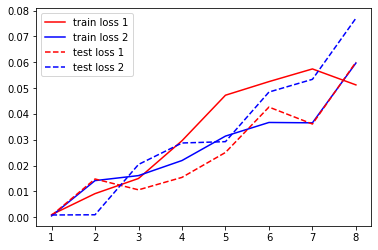

In [ ]:
train_loss1 = [0.00096,0.00912,0.01499,0.02960,0.04723,0.05250,0.05741,0.05123]
test_loss1 = [0.00069,0.01479,0.01059,0.01541,0.02506,0.04264,0.03608,0.06004]
train_loss2 = [0.00049,0.01416,0.01610,0.02194,0.03140,0.03668,0.03654,0.05968]
test_loss2 = [0.00085,0.000934,0.02042,0.02873,0.02925,0.04846,0.05338,0.07704]
sine_loss1=[0.01327,0.04617,0.09541,0.07621,0.023794,0.18312,0.21407,0.22249]
sine_loss2 = [0.00086,0.00768,0.04245,0.10675,0.10590,0.08422,0.10207,0.23905]
numb_of_waves = np.arange(1,9)
import matplotlib.pyplot as plt
plt.plot(numb_of_waves,train_loss1,'r-',label= "train loss 1")
# plt.plot(numb_of_waves,sine_loss1,'r.-',label ="sine loss 1")
plt.plot(numb_of_waves,train_loss2,'b-',label = "train loss 2")
plt.plot(numb_of_waves,test_loss1,'r--',label= "test loss 1")
plt.plot(numb_of_waves,test_loss2,'b--',label = "test loss 2")
# plt.plot(numb_of_waves,sine_loss2,'b.-',label = "sine loss 2")
plt.legend()

In [ ]:
# Random Codes
'''

print(x)
with open('dbx', 'rb') as f:
  meh = np.load(f,allow_pickle=True) 
print(np.shape(x))
print(np.shape(np.transpose(y[80])))
print(x)
print(y[80])
print((y[80].reshape(3)))
a =[[1.0421941],[0.8363143], [0.7082898]]
print(((avg_error_norm)**2)/(dimension),avg_mse)

'''

# temp = [[-4, -3, -2],
#        [-1,  0,  1],
#        [ 2,  3,  4]]

# temp2 = list(filter(lambda x: print(np.sum(x),"\n") ,temp))
# np.sum(temp2)
# print(np.sum(temp[0]))
# print(np.square(temp).mean())
# x,_ = generate_db_sine_multiple(mu,test_sigma,A,dimension,equations,1,min_freq,max_freq,1)
# print(x)

"\n\nprint(x)\nwith open('dbx', 'rb') as f:\n  meh = np.load(f,allow_pickle=True) \nprint(np.shape(x))\nprint(np.shape(np.transpose(y[80])))\nprint(x)\nprint(y[80])\nprint((y[80].reshape(3)))\na =[[1.0421941],[0.8363143], [0.7082898]]\nprint(((avg_error_norm)**2)/(dimension),avg_mse)\n\n"

In [ ]:
# #trying inverse using A Recurrent Neural Network for Real-Time Matrix Inversion* -Jun Wang
import numpy as np
# row = 4;col =5
# A = np.random.rand(row,row)
# A1 = np.array([[1,2,3,4],[5,6,7,8],[9,10,11,12]])
# # dv = np.zeros((row,col), dtype=int)
# v = np.zeros((row,row), dtype=float)
# ya = np.array([13,14,15],[16,17,18])
# ya= ya.reshape(3,1)
# print(A1,ya)
# A1 = np.append(A1,ya,axis=1)
# print(A1.reshape(1,15))
be = [1,2,3]
ce = [3,4,5]
de = [be,ce,be,be]
print(len(be), len(de),len(de[0]))
abc = np.random.rand(4,3)
defg = [abc,abc]
# defg = [defg,defg]
print(len(defg),len(defg[0]),len(defg[0][0]))
print(defg)
# print(y.reshape(3,1))

# eps = 1e-6
# n =10000
# delta = 1e4
# AT = delta*A.T
# # temp = -delta*np.matmul(A.T,A)
# A_inv = np.linalg.inv(A)
# I= np.eye(row, dtype=float)
# while n:
#   v = v- np.matmul(AT,np.arctan(np.matmul(A,v)-I ))
#   # print(np.linalg.norm(A_inv-v),"\n")
#   n-=1
# print(A,"\n\n",I  ,"\n\n",v,"\n\n",A_inv)
# S = random(1, 10, density=4/10)
# print(1*(S.A[0]>0))

3 4 3
2 4 3
[array([[0.17958206, 0.15919323, 0.67269042],
       [0.05231537, 0.60911247, 0.04843116],
       [0.48262107, 0.68885384, 0.82392098],
       [0.49670995, 0.19739309, 0.16888465]]), array([[0.17958206, 0.15919323, 0.67269042],
       [0.05231537, 0.60911247, 0.04843116],
       [0.48262107, 0.68885384, 0.82392098],
       [0.49670995, 0.19739309, 0.16888465]])]
